<a href="https://colab.research.google.com/github/Bitdribble/cs231n/blob/master/assignments/2021/assignment1/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.371123
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *On average, scores are initially equally distributed, and loss is approximated by exp(a)/(10*exp(a)) * 



In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.827925 analytic: -1.827925, relative error: 3.083203e-09
numerical: 2.596789 analytic: 2.596789, relative error: 6.693606e-09
numerical: -1.237186 analytic: -1.237186, relative error: 6.934479e-08
numerical: 1.672626 analytic: 1.672626, relative error: 1.664599e-08
numerical: 0.483524 analytic: 0.483524, relative error: 1.592339e-08
numerical: -5.451128 analytic: -5.451128, relative error: 2.145777e-09
numerical: -0.057070 analytic: -0.057070, relative error: 1.901708e-07
numerical: -1.914211 analytic: -1.914211, relative error: 6.332198e-09
numerical: -0.683349 analytic: -0.683349, relative error: 1.230083e-07
numerical: -1.776437 analytic: -1.776437, relative error: 8.702728e-10
numerical: 2.406939 analytic: 2.406939, relative error: 4.346079e-09
numerical: -0.918575 analytic: -0.918575, relative error: 1.902557e-08
numerical: -0.401627 analytic: -0.401627, relative error: 2.155301e-08
numerical: 1.860340 analytic: 1.860340, relative error: 2.646926e-08
numerical: 1.392

In [45]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.371123e+00 computed in 0.180008s
num_train=500, num_classes=10, num_data=3073
vectorized loss: 2.371123e+00 computed in 0.019493s
Loss difference: 0.000000
Gradient difference: 0.000000


In [50]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Wider range at the low end
learning_rates = [1e-8, 5e-5]
regularization_strengths = [1e-1, 5e4]

best_val = 0
best_lr = 0
best_reg = 0
best_softmax = None

for i in range(100):
  # Use log uniform sampling
  lr = np.exp(np.random.uniform(np.log(learning_rates[0]), 
                                np.log(learning_rates[1])))
  reg = np.exp(np.random.uniform(np.log(regularization_strengths[0]), 
                                 np.log(regularization_strengths[1])))

  softmax = Softmax()
  loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                            num_iters=1500, verbose=False)
  
  y_train_pred = softmax.predict(X_train)
  y_val_pred = softmax.predict(X_val)

  train_accuracy = np.mean(y_train == y_train_pred)
  val_accuracy = np.mean(y_val == y_val_pred)

  if best_val == 0 or val_accuracy > best_val:
    best_val = val_accuracy
    best_lr = lr
    best_reg = reg
    best_softmax = softmax

  print('%d: lr %e reg %e train accuracy: %f val accuracy: %f' % (
                i+1, lr, reg, train_accuracy, val_accuracy))

  results[(lr, reg)] = (train_accuracy, val_accuracy)

print("Hyperparameter tuning completed")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1: lr 2.594425e-07 reg 4.802774e+03 train accuracy: 0.374551 val accuracy: 0.395000
2: lr 5.761260e-07 reg 1.807274e+04 train accuracy: 0.338735 val accuracy: 0.354000
3: lr 7.326559e-07 reg 2.183121e+00 train accuracy: 0.331490 val accuracy: 0.332000
4: lr 2.603099e-07 reg 2.461131e-01 train accuracy: 0.286082 val accuracy: 0.278000
5: lr 4.745115e-06 reg 1.548729e+00 train accuracy: 0.389143 val accuracy: 0.376000
6: lr 3.367414e-08 reg 3.097011e+03 train accuracy: 0.224735 val accuracy: 0.245000
7: lr 2.339088e-05 reg 4.428078e+00 train accuracy: 0.266163 val accuracy: 0.275000
8: lr 1.317734e-06 reg 1.083021e-01 train accuracy: 0.360490 val accuracy: 0.370000
9: lr 3.577601e-05 reg 8.529243e+00 train accuracy: 0.312898 val accuracy: 0.321000
10: lr 5.948678e-06 reg 7.503545e+01 train accuracy: 0.376980 val accuracy: 0.364000
11: lr 1.238507e-07 reg 3.177406e-01 train accuracy: 0.261531 val accuracy: 0.259000
12: lr 4.528318e-07 reg 1.672609e+04 train accuracy: 0.348245 val accuracy

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:118: RuntimeWarning: overflow encountered in double_scalars
  dW += np.dot(X.T, coeff_X)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:118: RuntimeWarning: overflow encountered in multiply
  dW += np.dot(X.T, coeff_X)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:119: RuntimeWarning: overflow encountered in multiply
  


59: lr 4.283174e-05 reg 4.020327e+04 train accuracy: 0.100265 val accuracy: 0.087000
60: lr 2.335956e-07 reg 6.674513e+01 train accuracy: 0.283490 val accuracy: 0.293000
61: lr 1.854649e-08 reg 9.126442e+02 train accuracy: 0.184245 val accuracy: 0.184000
62: lr 2.473788e-05 reg 1.059788e+01 train accuracy: 0.285510 val accuracy: 0.276000
63: lr 3.208447e-07 reg 2.152302e+02 train accuracy: 0.311490 val accuracy: 0.302000
64: lr 1.258066e-05 reg 5.933721e-01 train accuracy: 0.328735 val accuracy: 0.314000
65: lr 7.521539e-08 reg 1.478772e+01 train accuracy: 0.227837 val accuracy: 0.232000
66: lr 1.005481e-05 reg 8.793669e+00 train accuracy: 0.336286 val accuracy: 0.330000
67: lr 7.528074e-07 reg 7.089169e+01 train accuracy: 0.346918 val accuracy: 0.345000
68: lr 1.165781e-06 reg 5.643858e+02 train accuracy: 0.403020 val accuracy: 0.398000
69: lr 8.154711e-08 reg 1.402694e+01 train accuracy: 0.233000 val accuracy: 0.242000
70: lr 1.435371e-06 reg 4.670138e-01 train accuracy: 0.363633 val

In [51]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True.


$\color{blue}{\textit Your Explanation:}$ Adding a datapoint to Softmax always increases the total loss, given that the softmax datapoint loss is > 0. Whereas a correctly classified datapoint to SVM has loss zero, so adding it as a datapoint does not increse the total loss.



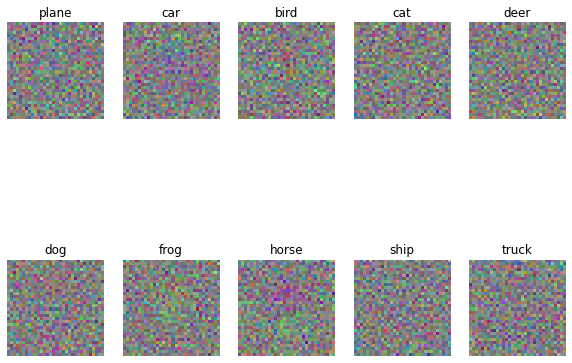

In [52]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])